## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
#%load_ext pycodestyle_magic
#%pycodestyle_on

## Read the data

In [3]:
churn_data = pd.read_csv('DATA_Customer-Churn.csv')
churn_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


## Short exploration

In [4]:
# Make all column names lowercase
churn_data.columns = [col.lower() for col in churn_data.columns]

In [5]:
# Check for missing values and data types
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   seniorcitizen     7043 non-null   int64  
 2   partner           7043 non-null   object 
 3   dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   phoneservice      7043 non-null   object 
 6   onlinesecurity    7043 non-null   object 
 7   onlinebackup      7043 non-null   object 
 8   deviceprotection  7043 non-null   object 
 9   techsupport       7043 non-null   object 
 10  streamingtv       7043 non-null   object 
 11  streamingmovies   7043 non-null   object 
 12  contract          7043 non-null   object 
 13  monthlycharges    7043 non-null   float64
 14  totalcharges      7043 non-null   object 
 15  churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

It seems like there are no missing values. However, when we try to convert the type in `TotalCharges`, we get a `ValueError`

```python
pd.to_numeric(churn_data['totalcharges'])
```
```
> ValueError: Unable to parse string " " 
```

Apparently some values are just a single space character `" "` (which probably represents missing data). Let's deal with them:

In [6]:
churn_data['totalcharges'] = pd.to_numeric(churn_data['totalcharges'], errors='coerce')  # invalid parsing will be set as NaN
churn_data['totalcharges'].fillna(
    churn_data['totalcharges'].mean(),
    inplace=True)  # replace NaN by the mean

In [7]:
# Check if the changes took place
print('churn_data[\'totalcharges\']\nDtype: {}\nMissing values: {}'.format(
    churn_data['totalcharges'].dtype,
    churn_data['totalcharges'].isna().sum())
     )

churn_data['totalcharges']
Dtype: float64
Missing values: 0


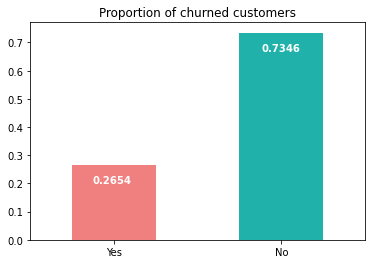

In [8]:
# Check the target variable
churn_data['churn'].value_counts(normalize=True, sort=True, ascending=True).plot.bar(rot=0, color=['LightCoral', 'LightSeaGreen'])

yes_label = churn_data['churn'].value_counts(normalize=True).round(4)['Yes']
no_label = churn_data['churn'].value_counts(normalize=True).round(4)['No']

plt.title('Proportion of churned customers')
plt.annotate(yes_label, xy=(0, 0.3), xytext=(-0.13, 0.2), color='white', weight='bold')
plt.annotate(no_label, xy=(1, 0.7), xytext=(0.88, 0.67), color='white', weight='bold')
plt.show()

The data is inbalanced: there are 2.8 times more customers that haven't churned.

## X/y split

In [9]:
X = churn_data.select_dtypes('number')
y = churn_data['churn']

## Train/test split and standardization

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [11]:
model_accuracy = dict()

## Logistic regression

In [12]:
log_reg = LogisticRegression().fit(X_train_scaled, y_train)
y_hat = log_reg.predict(X_test_scaled)

print(classification_report(y_test, y_hat, digits=4))

              precision    recall  f1-score   support

          No     0.8317    0.9257    0.8762      1036
         Yes     0.6992    0.4799    0.5692       373

    accuracy                         0.8077      1409
   macro avg     0.7655    0.7028    0.7227      1409
weighted avg     0.7967    0.8077    0.7949      1409



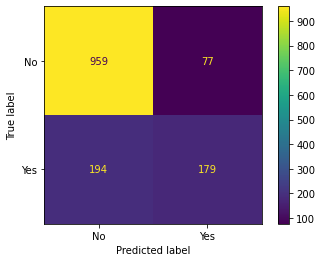

In [13]:
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(cm, display_labels=log_reg.classes_)
disp.plot()
plt.show()

In [14]:
model_accuracy['Logistic Regression'] = classification_report(y_test, y_hat, output_dict=True)['accuracy']

The overall accuracy is 0.8077. The model is better at predicting the label 'No' (recall = 0.9257), probably because of the inbalencement of the data (there are way more 'No' than 'Yes' labels).

## Decision Tree

In [15]:
dec_tree = DecisionTreeClassifier(random_state=42)
dec_tree.fit(X_train_scaled, y_train)

y_hat = dec_tree.predict(X_test_scaled)

print(classification_report(y_hat, y_test,  digits=4))

              precision    recall  f1-score   support

          No     0.8098    0.8185    0.8142      1025
         Yes     0.5013    0.4870    0.4941       384

    accuracy                         0.7282      1409
   macro avg     0.6556    0.6528    0.6541      1409
weighted avg     0.7258    0.7282    0.7269      1409



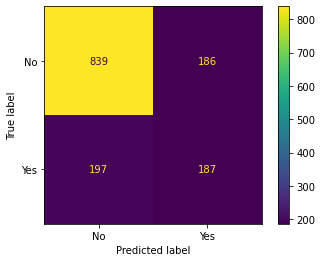

In [16]:
cm = confusion_matrix(y_hat, y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=dec_tree.classes_)
disp.plot()
plt.show()

In [17]:
model_accuracy['Decision Tree'] = classification_report(y_test, y_hat, output_dict=True)['accuracy']

### Cross-validation on the decision tree

In [18]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)
results = cross_val_score(dec_tree, X, y, cv=cv)

print('Accuracy: {:.4f}\nStandard deviation: {:.4f}'.format(results.mean(), results.std()))

Accuracy: 0.7179
Standard deviation: 0.0146


In [19]:
model_accuracy['CV on decision tree'] = results.mean()

## Random Forest

In [20]:
rdn_frst = RandomForestClassifier(random_state=42)
rdn_frst.fit(X_train_scaled, y_train)

y_hat = rdn_frst.predict(X_test_scaled)

print(classification_report(y_hat, y_test,  digits=4))

              precision    recall  f1-score   support

          No     0.8726    0.8196    0.8453      1103
         Yes     0.4665    0.5686    0.5125       306

    accuracy                         0.7651      1409
   macro avg     0.6695    0.6941    0.6789      1409
weighted avg     0.7844    0.7651    0.7730      1409



In [21]:
rdn_frst = RandomForestClassifier(random_state=42)
rdn_frst.fit(X_train, y_train)

y_hat = rdn_frst.predict(X_test)

print(classification_report(y_hat, y_test,  digits=4))

              precision    recall  f1-score   support

          No     0.8755    0.8186    0.8461      1108
         Yes     0.4611    0.5714    0.5104       301

    accuracy                         0.7658      1409
   macro avg     0.6683    0.6950    0.6782      1409
weighted avg     0.7870    0.7658    0.7744      1409



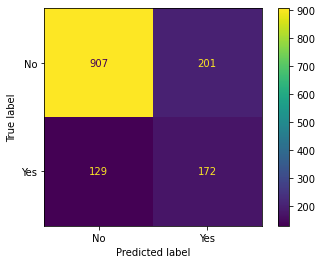

In [22]:
cm = confusion_matrix(y_hat, y_test)
disp = ConfusionMatrixDisplay(cm, display_labels=rdn_frst.classes_)
disp.plot()
plt.show()

In [23]:
model_accuracy['Random Forest'] = classification_report(y_test, y_hat, output_dict=True)['accuracy']

## Summary

In [24]:
pd.DataFrame([model_accuracy])

,Logistic Regression,Decision Tree,CV on decision tree,Random Forest
0,0.807665,0.728176,0.717877,0.765791
